# Import the libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import math

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans

# Data Preparation

In [36]:
df_patient = pd.read_csv('DATA/patient.csv')
df_route = pd.read_csv('DATA/route.csv')
df_time = pd.read_csv('DATA/time.csv')

In [5]:
df_patient.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [6]:
df_patient.isna().sum()

patient_id             0
sex                 7076
birth_year          7089
country                0
region              7318
disease             7726
group               7668
infection_reason    7600
infection_order     7718
infected_by         7684
contact_number      7701
confirmed_date         0
released_date       7699
deceased_date       7718
state                  0
dtype: int64

# Feature Engineering

In [7]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).patient_id.count()
accumulated_count = daily_count.cumsum()
df_patient['age'] = 2020 - df_patient['birth_year'] 

In [8]:
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"

In [9]:
df_patient["age_range"] = df_patient["age"].apply(group_age)

In [10]:
patient=df_patient

In [11]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [12]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]
released = df_patient[df_patient.state == 'released']
isolated_state = df_patient[df_patient.state == 'isolated']
dead = df_patient[df_patient.state == 'deceased']

# Confirmed Cases

Text(0.5, 1.0, 'Accumulated Confirmed Count')

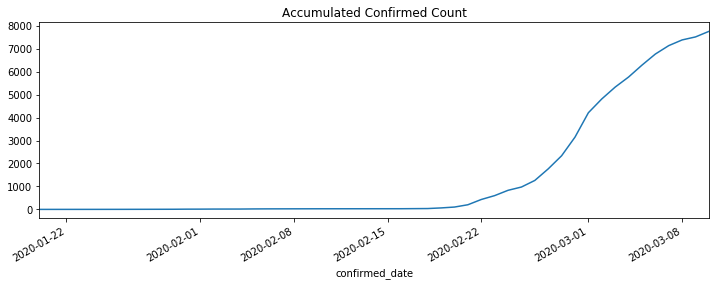

In [13]:
plt.figure(figsize=(12,4))
accumulated_count.plot()
plt.title('Accumulated Confirmed Count')

In [14]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



,id,latitude,longitude
0,NaN,37.460459,126.440680
1,NaN,37.478832,126.668558
2,NaN,37.562143,126.801884
3,NaN,37.567454,127.005627
4,NaN,37.460459,126.440680
5,NaN,37.524978,127.027718
6,NaN,37.503359,127.049177
7,NaN,37.524669,127.015911
8,NaN,37.529200,127.032597
9,NaN,37.674192,126.776955


# Checking number of Cluster

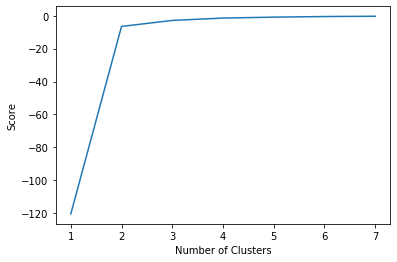

In [15]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [16]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

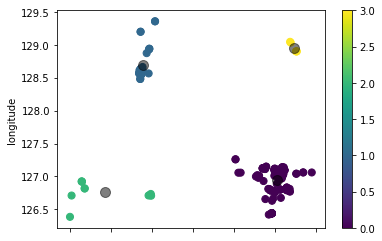

In [17]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

# Data Prep for LSTM

In [18]:
data = daily_count.resample('D').first().fillna(0).cumsum()
data = data[20:]
x = np.arange(len(data)).reshape(-1, 1)
y = data.values

In [19]:
x.shape

(31, 1)

# Regressor Model

In [20]:
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [21]:
test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)

In [22]:
pred = pred.reshape(38,)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)

In [23]:
predicted_count = pd.Series(prediction, dt_idx)

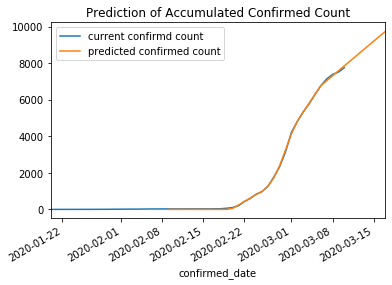

In [24]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

# LSTM With Tensorflow

In [25]:
dataset = pd.DataFrame(data)
dataset.columns = ['Confirmed']
dataset.head()

,Confirmed
confirmed_date,
2020-02-09,27.0
2020-02-10,28.0
2020-02-11,28.0
2020-02-12,28.0
2020-02-13,28.0


In [26]:
data = np.array(dataset).reshape(-1, 1)
train_data = dataset[:len(dataset)-5]
test_data = dataset[len(dataset)-5:]

In [27]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1

In [28]:
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

In [29]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 30)

Train for 21 steps
Epoch 1/30
21/21 [==============================] - 15s 712ms/step - loss: 0.1549
Epoch 2/30
21/21 [==============================] - 0s 23ms/step - loss: 0.0800
Epoch 3/30
21/21 [==============================] - 1s 24ms/step - loss: 0.0522
Epoch 4/30
21/21 [==============================] - 1s 27ms/step - loss: 0.0294: 0s - loss:
Epoch 5/30
21/21 [==============================] - 0s 23ms/step - loss: 0.0320
Epoch 6/30
21/21 [==============================] - 0s 23ms/step - loss: 0.0408
Epoch 7/30
21/21 [==============================] - 0s 23ms/step - loss: 0.0254
Epoch 8/30
21/21 [==============================] - ETA: 0s - loss: 0.022 - 0s 23ms/step - loss: 0.0210
Epoch 9/30
21/21 [==============================] - 0s 23ms/step - loss: 0.0192
Epoch 10/30
21/21 [==============================] - 0s 22ms/step - loss: 0.0169
Epoch 11/30
21/21 [==============================] - 0s 24ms/step - loss: 0.0174
Epoch 12/30
21/21 [==============================] - 0s 23ms/

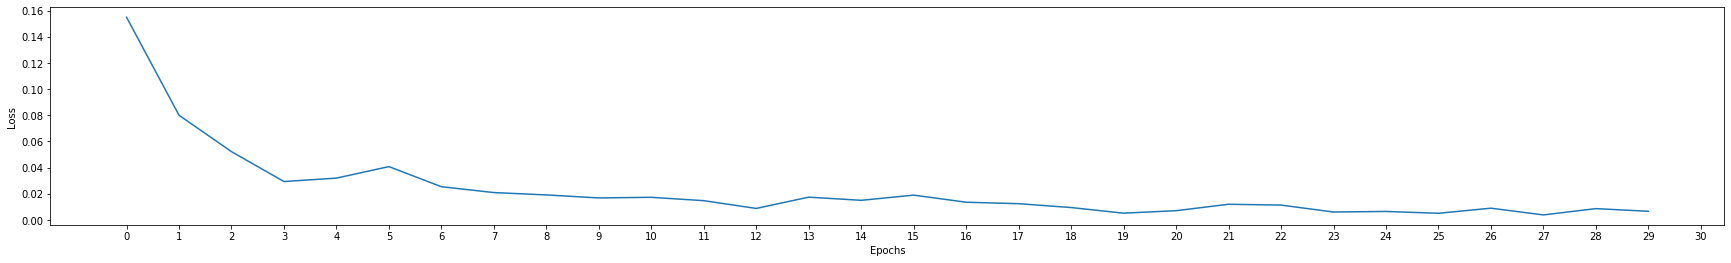

In [30]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [31]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [32]:
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head()

,0
0,6883.454910
1,7085.078455
2,7237.630861
3,7360.536541
4,7467.989798


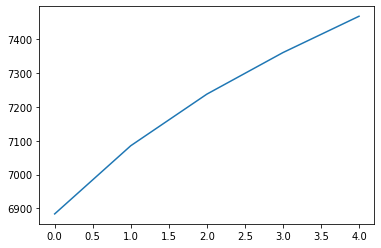

In [33]:
plt.plot(prediction)